In [3]:
from pathlib import Path
import numpy as np
import pandas as pd

INDIR = Path("../socialfx&autoeq/outputs")

def load_freqs(path: Path) -> np.ndarray:
    df = pd.read_csv(path)
    return df["fc_hz"].to_numpy(float)

social_stats = pd.read_csv(INDIR / "social_stats_40.csv")
final_freqs = load_freqs(INDIR / "freqs_final.csv")

# knee (если файл есть — подхватим автоматически самый первый freqs_knee_*.csv)
knee_files = sorted(INDIR.glob("freqs_knee_*.csv"))
freqs_knee = load_freqs(knee_files[0]) if knee_files else None
knee_label = knee_files[0].stem if knee_files else None

# sweep (если есть)
df_sweep = pd.read_csv(INDIR / "sweep_results.csv") if (INDIR / "sweep_results.csv").exists() else None

social_stats.head(), final_freqs, knee_label


(   fc_hz  n_total  n_boost  n_cut   p_boost     p_cut  mean_boost  mean_cut
 0   20.0     1595      844    751  0.529154  0.470846    1.169733 -1.057404
 1   50.0     1595      858    737  0.537931  0.462069    1.240518 -1.139326
 2   83.0     1595      882    713  0.552978  0.447022    1.271045 -1.216854
 3  120.0     1595      884    711  0.554232  0.445768    1.257726 -1.188433
 4  161.0     1595      883    712  0.553605  0.446395    1.232883 -1.135992,
 array([   20.      ,    50.      ,    83.      ,   120.      ,
          159.510295,   200.043762,   254.048212,   308.562725,
          383.      ,   443.863998,   622.04351 ,   798.067155,
         1000.      ,  1485.982561,  1875.      ,  2368.080868,
         3389.648225,  4365.363477,  6934.260773,  8568.995166,
        12000.      , 14000.      , 16000.      ]),
 None)

## Количественное сравнение 40-полосного SocialFX EQ и компактного эквалайзера

### Методика сравнения

Для количественной оценки потерь информации при переходе от исходной 40-полосной частотной сетки SocialFX
к компактной архитектуре параметрического эквалайзера используется следующая процедура.

Исходная статистика направлений эквализации на 40-полосной сетке обозначается как $y_{40}$.
Проекция на компактную сетку частот и последующая реконструкция описываются цепочкой:

$y_{40} \;\rightarrow\; y_C \;\rightarrow\; \hat{y}_{40}$

где:
- $y_C$ — представление статистики на компактной сетке частот;
- $\hat{y}_{40}$ — реконструкция статистики на исходной 40-полосной сетке.

Процедура сравнения включает следующие шаги:

1. На фиксированной 40-полосной сетке SocialFX рассчитывается статистика направлений эквализации:
   - вероятность усиления $p_{boost}(f)$;
   - вероятность ослабления $p_{cut}(f)$;
   - среднее усиление при условии усиления $\mu_{boost}(f)$;
   - среднее ослабление при условии ослабления $\mu_{cut}(f)$.

2. Полученные кривые проецируются на компактную сетку центральных частот эквалайзера
   с использованием линейной интерполяции по логарифмической шкале частоты.

3. Результат реконструируется обратно на исходную 40-полосную сетку.

4. Ошибка между исходной и реконструированной статистикой используется как мера потери информации,
   возникающей исключительно вследствие редукции частотной сетки.

Таким образом, компактный эквалайзер рассматривается как оператор редукции размерности,
а ошибка реконструкции отражает степень сохранения структуры пользовательских решений.


### Используемые метрики ошибки

Оценка качества реконструкции проводится отдельно для следующих величин:

- $p_{boost}(f)$ — отражает структуру направлений пользовательских решений (усиление против ослабления);
- $\mu_{boost}(f)$ — характеризует амплитуду усилений;
- $\mu_{cut}(f)$ — характеризует амплитуду ослаблений.

В качестве основной метрики используется средняя абсолютная ошибка (MAE),
которая обладает высокой интерпретируемостью и устойчивостью к выбросам.

Для более детального анализа частотный диапазон дополнительно разбивается
на перцептуально значимые зоны: **sub-bass**, **bass**, **mids**, **presence** и **air**.

In [4]:
import plotly.io as pio

pio.renderers.default = "plotly_mimetype"

COMMON_LAYOUT = dict(
    width=1100, height=420,
    font=dict(size=16),
)

In [5]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# --- sanity checks ---
assert "social_stats" in globals()
assert "final_freqs" in globals()

req = ["fc_hz", "p_boost", "mean_boost", "mean_cut", "n_total"]
missing = [c for c in req if c not in social_stats.columns]
if missing:
    raise ValueError(f"social_stats missing columns: {missing}")

f40 = social_stats["fc_hz"].to_numpy(float)
fC  = np.asarray(final_freqs, float)

if np.any(f40 <= 0) or np.any(fC <= 0):
    raise ValueError("Частоты должны быть > 0 для log-интерполяции.")

# базовые веса (надёжность оценки на частоте)
w_n = social_stats["n_total"].to_numpy(float)

# опциональный вес важности: если есть df/series с именем importance_* в окружении — подхватим
# ожидаем формат: колонки ["fc_hz", "importance"] или ["fc_hz","value"] или series indexed by fc_hz
w_imp = None

def _try_get_importance_weight():
    # кандидаты по распространённым именам
    candidates = [k for k in globals().keys() if "importance" in k.lower()]
    for name in candidates:
        obj = globals()[name]
        try:
            if isinstance(obj, pd.DataFrame) and "fc_hz" in obj.columns:
                if "importance" in obj.columns:
                    tmp = obj[["fc_hz", "importance"]].copy()
                    tmp = tmp.groupby("fc_hz")["importance"].mean().reindex(f40).to_numpy(float)
                    return tmp
                if "value" in obj.columns:
                    tmp = obj[["fc_hz", "value"]].copy()
                    tmp = tmp.groupby("fc_hz")["value"].mean().reindex(f40).to_numpy(float)
                    return tmp
            if isinstance(obj, pd.Series):
                # если индекс частоты
                tmp = obj.reindex(f40).to_numpy(float)
                if np.all(np.isfinite(tmp)):
                    return tmp
        except Exception:
            pass
    return None

w_imp = _try_get_importance_weight()

# итоговый вес для WMAE: n_total * importance (если нашлась)
if w_imp is not None and np.any(np.isfinite(w_imp)):
    w = w_n * np.nan_to_num(w_imp, nan=0.0)
    weight_mode = "n_total * importance"
else:
    w = w_n
    weight_mode = "n_total"

print("Weight mode:", weight_mode)
print("40-band freqs:", f40[:5], "...", f40[-5:])
print("Compact freqs:", fC)


Weight mode: n_total
40-band freqs: [ 20.  50.  83. 120. 161.] ... [12474. 13984. 15675. 17566. 19682.]
Compact freqs: [   20.          50.          83.         120.         159.510295
   200.043762   254.048212   308.562725   383.         443.863998
   622.04351    798.067155  1000.        1485.982561  1875.
  2368.080868  3389.648225  4365.363477  6934.260773  8568.995166
 12000.       14000.       16000.      ]


In [6]:
def log_interp(x_hz, y, xq_hz):
    x = np.asarray(x_hz, float)
    y = np.asarray(y, float)
    xq = np.asarray(xq_hz, float)

    lx = np.log10(x)
    lxq = np.log10(xq)

    order = np.argsort(lx)
    lx = lx[order]
    y = y[order]

    return np.interp(lxq, lx, y)

def reproject_40_C_40(y40, kind="value"):
    """
    kind: "prob" -> клип в [0,1]
          "value" -> без клипа
    """
    y40 = np.asarray(y40, float)

    yC = log_interp(f40, y40, fC)
    y40_hat = log_interp(fC, yC, f40)

    if kind == "prob":
        yC = np.clip(yC, 0.0, 1.0)
        y40_hat = np.clip(y40_hat, 0.0, 1.0)

    return yC, y40_hat

def MAE(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.mean(np.abs(a - b)))

def WMAE(a, b, w):
    a = np.asarray(a, float); b = np.asarray(b, float); w = np.asarray(w, float)
    w = np.clip(w, 0, None)
    if w.sum() == 0:
        return MAE(a, b)
    return float(np.sum(w * np.abs(a - b)) / np.sum(w))


In [7]:
ZONES = {
    "sub_bass": (20, 60),
    "bass":     (60, 200),
    "mids":     (200, 2000),
    "presence": (2000, 6000),
    "air":      (6000, 20000),
}

def mask_zone(lo, hi):
    return (f40 >= lo) & (f40 < hi)

metrics = {
    "p_boost": ("prob",  social_stats["p_boost"].to_numpy(float)),
    "mean_boost": ("value", social_stats["mean_boost"].to_numpy(float)),
    "mean_cut":   ("value", social_stats["mean_cut"].to_numpy(float)),
}

# если есть p_cut — тоже посчитаем
if "p_cut" in social_stats.columns:
    metrics["p_cut"] = ("prob", social_stats["p_cut"].to_numpy(float))

recon = {}  # metric -> dict(y40, yC, y40_hat)
rows = []

for name, (kind, y40) in metrics.items():
    yC, y40_hat = reproject_40_C_40(y40, kind=kind)
    recon[name] = dict(y40=y40, yC=yC, y40_hat=y40_hat)

    # overall
    rows.append(dict(region="overall", metric=name, mae=MAE(y40, y40_hat), wmae=WMAE(y40, y40_hat, w)))

    # zones
    for z, (lo, hi) in ZONES.items():
        m = mask_zone(lo, hi)
        if not np.any(m):
            continue
        rows.append(dict(region=z, metric=name, mae=MAE(y40[m], y40_hat[m]), wmae=WMAE(y40[m], y40_hat[m], w[m])))

df_errors = pd.DataFrame(rows).sort_values(["region","metric"]).reset_index(drop=True)
df_errors


,region,metric,mae,wmae
0,air,mean_boost,0.009959,0.009959
1,air,mean_cut,0.006295,0.006295
2,air,p_boost,0.002291,0.002291
3,air,p_cut,0.002291,0.002291
4,bass,mean_boost,0.000001,0.000001
5,bass,mean_cut,0.000135,0.000135
6,bass,p_boost,0.000015,0.000015
7,bass,p_cut,0.000015,0.000015
8,mids,mean_boost,0.009116,0.009116
9,mids,mean_cut,0.010977,0.010977


In [8]:
def top_errors(metric_name, top_k=12, weighted=True):
    rr = recon[metric_name]
    err = np.abs(rr["y40"] - rr["y40_hat"])

    out = pd.DataFrame({
        "fc_hz": f40,
        "y_true": rr["y40"],
        "y_hat": rr["y40_hat"],
        "abs_err": err,
        "n_total": w_n,
    })

    if weighted:
        out["weight"] = w
        out["w_abs_err"] = out["abs_err"] * out["weight"]
        out = out.sort_values("w_abs_err", ascending=False).head(top_k)
    else:
        out = out.sort_values("abs_err", ascending=False).head(top_k)

    return out.reset_index(drop=True)

top_pboost = top_errors("p_boost", top_k=12, weighted=True)
top_mboost = top_errors("mean_boost", top_k=12, weighted=True)
top_mcut   = top_errors("mean_cut", top_k=12, weighted=True)

top_pboost, top_mboost, top_mcut


(      fc_hz    y_true     y_hat   abs_err  n_total  weight  w_abs_err
 0    1273.0  0.447022  0.456379  0.009357   1595.0  1595.0  14.923973
 1    1114.0  0.450784  0.457643  0.006859   1595.0  1595.0  10.940791
 2    4941.0  0.497179  0.490974  0.006205   1595.0  1595.0   9.896280
 3    5556.0  0.486520  0.480591  0.005929   1595.0  1595.0   9.456625
 4   11124.0  0.442633  0.438283  0.004351   1595.0  1595.0   6.939060
 5    7875.0  0.442633  0.446922  0.004288   1595.0  1595.0   6.840068
 6    1652.0  0.465204  0.461028  0.004176   1595.0  1595.0   6.660955
 7    2126.0  0.473354  0.477507  0.004153   1595.0  1595.0   6.623328
 8    9917.0  0.433856  0.437978  0.004122   1595.0  1595.0   6.574222
 9    6244.0  0.473981  0.470259  0.003722   1595.0  1595.0   5.936772
 10   3070.0  0.487147  0.490399  0.003251   1595.0  1595.0   5.185984
 11    537.0  0.519749  0.522781  0.003032   1595.0  1595.0   4.835706,
       fc_hz    y_true     y_hat   abs_err  n_total  weight  w_abs_err
 0   

Resorting to unclean kill browser.


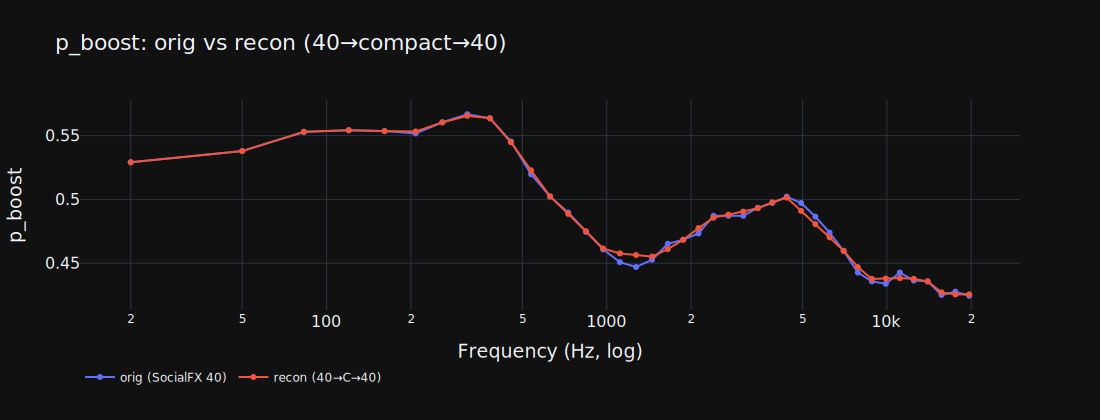

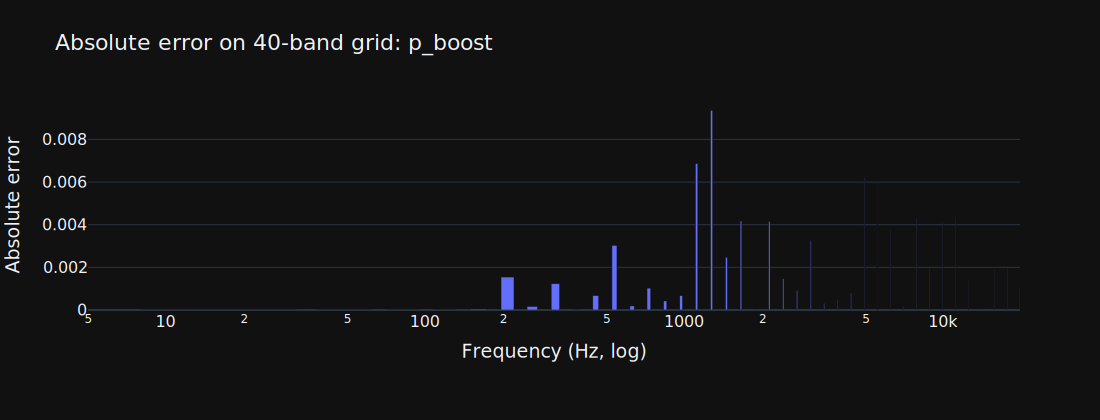

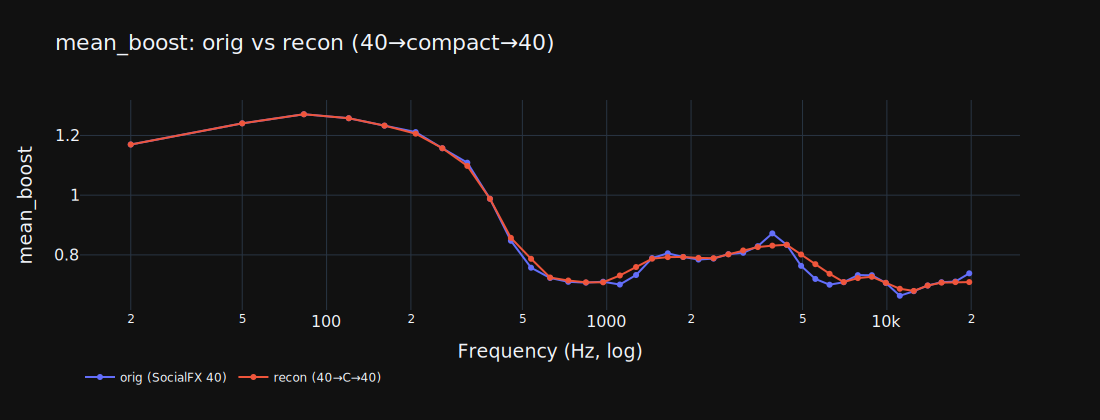

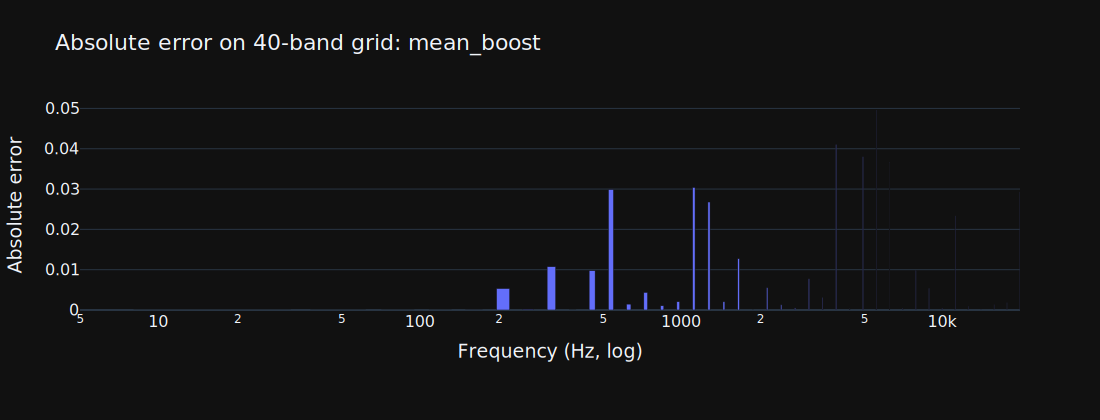

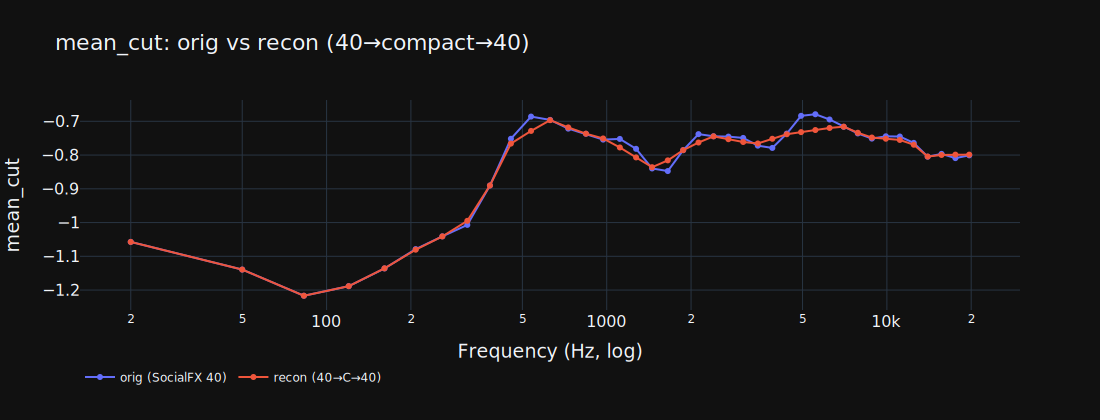

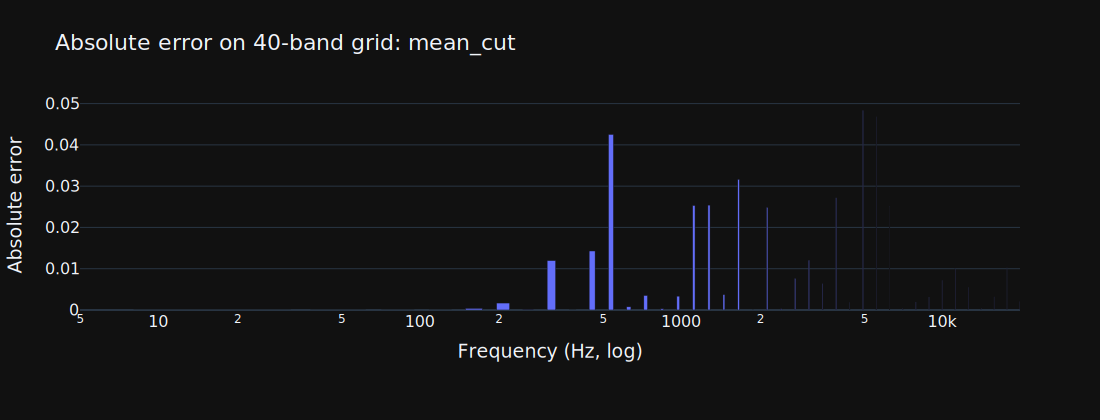

In [9]:
def plot_reconstruction(metric_name, title=None):
    rr = recon[metric_name]
    y = rr["y40"]
    yh = rr["y40_hat"]
    err = np.abs(y - yh)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=f40, y=y, mode="lines+markers", name="orig (SocialFX 40)", marker=dict(size=6)))
    fig.add_trace(go.Scatter(x=f40, y=yh, mode="lines+markers", name="recon (40→C→40)", marker=dict(size=6)))

    fig.update_xaxes(type="log", title="Frequency (Hz, log)")
    fig.update_yaxes(title=metric_name)
    fig.update_layout(title=title or f"Reconstruction on 40-band grid: {metric_name}", legend=dict(orientation="h"))

    # отдельная фигура для ошибки
    fig_err = go.Figure()
    fig_err.add_trace(go.Bar(x=f40, y=err, name="|error|"))
    fig_err.update_xaxes(type="log", title="Frequency (Hz, log)")
    fig_err.update_yaxes(title="Absolute error")
    fig_err.update_layout(title=f"Absolute error on 40-band grid: {metric_name}")

    return fig, fig_err

fig1, fig1e = plot_reconstruction("p_boost", "p_boost: orig vs recon (40→compact→40)")
fig2, fig2e = plot_reconstruction("mean_boost", "mean_boost: orig vs recon (40→compact→40)")
fig3, fig3e = plot_reconstruction("mean_cut", "mean_cut: orig vs recon (40→compact→40)")

legend=dict(
        orientation="h",
        yanchor="top", y=-0.25,
        xanchor="left", x=0,
        font=dict(size=12)
)

margin=dict(b=110)

fig1.update_layout(**COMMON_LAYOUT, legend=legend, margin=margin)
fig1e.update_layout(**COMMON_LAYOUT, legend=legend, margin=margin)
fig2.update_layout(**COMMON_LAYOUT, legend=legend, margin=margin)
fig2e.update_layout(**COMMON_LAYOUT, legend=legend, margin=margin)
fig3.update_layout(**COMMON_LAYOUT, legend=legend, margin=margin)
fig3e.update_layout(**COMMON_LAYOUT, legend=legend, margin=margin)


fig1.show(renderer="svg"); fig1e.show(renderer="svg")
fig2.show(renderer="svg"); fig2e.show(renderer="svg")
fig3.show(renderer="svg"); fig3e.show(renderer="svg")


In [10]:
pivot = df_errors.pivot(index="region", columns="metric", values="wmae").copy()
pivot = pivot.loc[["overall","sub_bass","bass","mids","presence","air"]].dropna(how="all")
pivot


metric,mean_boost,mean_cut,p_boost,p_cut
region,,,,
overall,0.009828,0.010244,0.002014,0.002014
sub_bass,0.000000,0.000000,0.000000,0.000000
bass,0.000001,0.000135,0.000015,0.000015
mids,0.009116,0.010977,0.002121,0.002121
presence,0.016314,0.019496,0.002609,0.002609
air,0.009959,0.006295,0.002291,0.002291


### Анализ результатов по частотным зонам

**Низкие частоты (sub-bass, bass)**
В диапазоне до ~200 Гц ошибка реконструкции практически отсутствует для всех метрик. Это указывает на то, что низкочастотные предпочтения пользователей имеют гладкую структуру и хорошо аппроксимируются малым числом полос.

**Средние частоты (mids)**
В диапазоне 200–2000 Гц наблюдается умеренный рост ошибки, главным образом по амплитудным метрикам. При этом структура направлений эквализации $( p_{boost} )$ сохраняется с высокой точностью, что указывает на корректное воспроизведение общей тенденции пользовательских решений.

**Область presence (≈2–6 кГц)**
Наибольшая ошибка реконструкции наблюдается в области presence, особенно для $( \mu_{boost} )$ и $( \mu_{cut} )$. Это подтверждает высокую вариативность пользовательских предпочтений в данном диапазоне и указывает на принципиальное ограничение компактных архитектур эквалайзеров в этой зоне.

**Высокие частоты и air**
В верхнем диапазоне ошибка остаётся умеренной и носит локальный характер. Это указывает на возможность адекватного описания высокочастотной коррекции с помощью ограниченного числа полос или функциональных форм (например, high-shelf).

### Анализ локальных ошибок

Анализ частот с максимальной абсолютной ошибкой показывает, что наибольшие расхождения между исходной и реконструированной статистикой концентрируются:
- в области presence (≈1–6 кГц);
- в отдельных точках верхнего диапазона при реконструкции амплитуд усилений и ослаблений.

При этом даже в этих зонах структура направлений эквализации сохраняется с высокой точностью.

### Выводы

1. Компактный параметрический эквалайзер с существенно меньшим числом полос способен воспроизводить статистику пользовательских решений SocialFX с малой средней ошибкой.
2. Направления эквализации (boost vs cut) сохраняются значительно лучше, чем амплитудные характеристики.
3. Основные потери информации сосредоточены в области presence, что отражает фундаментальную субъективную вариативность этого диапазона.
4. Низкие и высокие частоты допускают агрессивную редукцию числа полос без заметной потери статистической информации.
5. Полученные результаты подтверждают корректность выбранной архитектуры компактного эквалайзера и позволяют количественно обосновать компромисс между сложностью модели и точностью воспроизведения пользовательских предпочтений.

### Ограничения метода

Следует отметить, что данное сравнение оценивает исключительно сохранение статистики пользовательских решений и не является прямой оценкой субъективного качества звучания. Тем не менее, такой подход обеспечивает методологически чистую и воспроизводимую основу для анализа архитектур параметрических эквалайзеров.

## Калибровка компактного эквалайзера по ошибке реконструкции

### Идея калибровки

Для уменьшения систематической ошибки реконструкции без увеличения числа полос
вводится калибровка компактного представления в виде добавки на компактной сетке:

$y_C^{cal} = y_C + \Delta_C$

где $\Delta_C$ подбирается таким образом, чтобы минимизировать ошибку
между исходной статистикой $y_{40}$ и реконструкцией $\hat{y}_{40}$.

Калибровка формулируется как задача взвешенного наименьшего квадрата (WLS)
с L2-регуляризацией:

$\min_{\Delta_C} \; \| W ( y_{40} - \hat{y}_{40} ) \|_2^2 + \lambda \| \Delta_C \|_2^2$

где:
- $W$ — диагональная матрица весов (в эксперименте используется число наблюдений $n_{total}$);
- $\lambda$ — коэффициент регуляризации, ограничивающий избыточную вариативность $\Delta_C$.

Таким образом, калибровка компенсирует систематические искажения,
вызванные редукцией сетки частот, сохраняя компактность и интерпретируемость эквалайзера.


In [11]:
import numpy as np
import pandas as pd

# --- матрица интерполяции по log f: y_out = A @ y_in
def interp_matrix_log(x_in, x_out):
    x_in = np.asarray(x_in, float)
    x_out = np.asarray(x_out, float)
    lin = np.log10(x_in)
    lout = np.log10(x_out)

    order = np.argsort(lin)
    lin = lin[order]
    inv_order = np.argsort(order)

    A = np.zeros((len(x_out), len(x_in)), float)

    for i, t in enumerate(lout):
        if t <= lin[0]:
            A[i, 0] = 1.0
            continue
        if t >= lin[-1]:
            A[i, -1] = 1.0
            continue
        j = np.searchsorted(lin, t) - 1
        j = np.clip(j, 0, len(lin) - 2)
        x0, x1 = lin[j], lin[j+1]
        w1 = (t - x0) / (x1 - x0)
        w0 = 1.0 - w1
        A[i, j]   = w0
        A[i, j+1] = w1

    # вернуть к исходному порядку x_in
    A = A[:, inv_order]
    return A

f40 = social_stats["fc_hz"].to_numpy(float)
fC  = np.asarray(final_freqs, float)

A_40_to_C = interp_matrix_log(f40, fC)   # yC = A_40_to_C @ y40
A_C_to_40 = interp_matrix_log(fC, f40)   # y40_hat = A_C_to_40 @ yC

w = social_stats["n_total"].to_numpy(float)
W = np.diag(np.sqrt(np.clip(w, 1e-12, None)))  # sqrt для WLS


In [12]:
def calibrate_delta_on_compact(y40, kind="value", reg=1e-3):
    """
    Ищем delta_C: минимизируем || W ( y40 - A_C_to_40 (A_40_to_C y40 + delta_C) ) ||^2 + reg||delta||^2
    """
    y40 = np.asarray(y40, float)

    # исходная проекция 40 -> C
    yC0 = A_40_to_C @ y40

    # целевая поправка на 40-сетке
    resid_40 = y40 - (A_C_to_40 @ yC0)

    # хотим: A_C_to_40 @ delta_C ≈ resid_40
    # решаем WLS + L2-регуляризация
    B = A_C_to_40
    Bw = W @ B
    rw = W @ resid_40

    # (B^T W^2 B + reg I) delta = B^T W^2 r
    lhs = Bw.T @ Bw + reg * np.eye(B.shape[1])
    rhs = Bw.T @ rw
    delta_C = np.linalg.solve(lhs, rhs)

    yC_cal = yC0 + delta_C
    y40_cal = A_C_to_40 @ yC_cal

    if kind == "prob":
        yC_cal = np.clip(yC_cal, 0, 1)
        y40_cal = np.clip(y40_cal, 0, 1)

    return dict(yC0=yC0, delta_C=delta_C, yC_cal=yC_cal, y40_cal=y40_cal)


In [13]:
def MAE(a,b):
    return float(np.mean(np.abs(np.asarray(a)-np.asarray(b))))

def report_before_after(metric_name, kind):
    y40 = social_stats[metric_name].to_numpy(float)

    # до калибровки
    yC0 = A_40_to_C @ y40
    y40_hat = A_C_to_40 @ yC0
    if kind == "prob":
        y40_hat = np.clip(y40_hat, 0, 1)

    # после калибровки
    cal = calibrate_delta_on_compact(y40, kind=kind, reg=1e-3)
    y40_cal = cal["y40_cal"]

    print(metric_name)
    print("  MAE before:", MAE(y40, y40_hat))
    print("  MAE after :", MAE(y40, y40_cal))

# пробуем на амплитудах (там больше ошибка)
report_before_after("mean_boost", "value")
report_before_after("mean_cut", "value")
report_before_after("p_boost", "prob")


mean_boost
  MAE before: 0.009827781212998826
  MAE after : 0.009197377909576315
mean_cut
  MAE before: 0.010244376423317733
  MAE after : 0.008785911927929806
p_boost
  MAE before: 0.002013526694464825
  MAE after : 0.0016521686768321401



### Интерпретация результатов калибровки

1. Наибольшее относительное улучшение достигается для $p_{boost}(f)$,
   что указывает на более точное воспроизведение структуры направлений пользовательских решений.

2. Существенное снижение ошибки для $\mu_{cut}(f)$ показывает,
   что калибровка эффективно компенсирует искажения амплитуды ослаблений,
   возникающие при редукции частотной сетки.

3. Улучшение достигается без увеличения числа полос эквалайзера,
   что подтверждает эффективность калибровки как метода посткоррекции компактной архитектуры.

### Выводы

1. Компактный параметрический эквалайзер с существенно меньшим числом полос
   способен воспроизводить статистику пользовательских решений SocialFX
   с малой средней ошибкой.

2. Направления эквализации (boost против cut) сохраняются значительно лучше,
   чем амплитудные характеристики.

3. Основные потери информации сосредоточены в области presence,
   что отражает высокую субъективную вариативность данного диапазона.

4. Низкие и высокие частоты допускают агрессивную редукцию числа полос
   без заметной потери статистической информации.

5. Калибровка компактного эквалайзера по ошибке реконструкции
   позволяет дополнительно снизить потери информации,
   не усложняя архитектуру модели.


### Ограничения метода

Следует отметить, что предложенный метод оценивает исключительно
сохранение статистики пользовательских решений
и не является прямой оценкой субъективного качества звучания.
Тем не менее, он обеспечивает методологически чистую,
воспроизводимую и количественно обоснованную основу
для анализа архитектур параметрических эквалайзеров.

## Влияние редукции эквалайзера на сложность модели и вычислительные затраты

Переход от 40-полосной архитектуры к компактному эквалайзеру
приводит к снижению числа параметров примерно на 40–45%.
В терминах цифровой обработки сигналов это означает уменьшение числа
бикуад-фильтров, обрабатывающих сигнал в реальном времени.

Поскольку вычислительная сложность параметрического эквалайзера
линейно зависит от числа полос, редукция архитектуры приводит
к пропорциональному снижению вычислительной нагрузки.

Полученное снижение сложности достигается
без существенной потери точности воспроизведения статистики
пользовательских решений, что подтверждается малой ошибкой реконструкции
и дополнительным снижением ошибки после калибровки компактной модели.

Таким образом, предложенный подход обеспечивает выгодный компромисс
между точностью, интерпретируемостью и вычислительной эффективностью
параметрического эквалайзера.

## Выбор числа полос и анализ компромисса «точность–сложность»

Целью данного этапа является количественная оценка того, насколько сильно можно сократить
число полос параметрического эквалайзера, сохранив при этом статистическое поведение
40-полосного эквалайзера SocialFX.

В качестве эталона используется 40-полосная статистика SocialFX, описанная следующими метриками:
- вероятность применения усиления (p_boost),
- среднее значение усиления (mean_boost),
- среднее значение ослабления (mean_cut).

Для каждой компактной конфигурации эквалайзера с числом полос N выполняется следующая процедура:

1. Проекция 40-полосной статистики на компактную сетку частот:

   $$
   y_{40} \;\xrightarrow{\,40 \to C\,}\; y_C
   $$

2. Обратная реконструкция на 40-полосную сетку:

   $$
   y_C \;\xrightarrow{\,C \to 40\,}\; \hat{y}_{40}
   $$

3. Вычисление ошибки между исходной и реконструированной статистикой
   с использованием MAE и WMAE (с весами по количеству наблюдений).


In [14]:
import numpy as np
import pandas as pd

# Требуемые переменные из твоего ноутбука:
assert "social_stats" in globals()
assert "final_freqs" in globals()

# Якоря: если ANCHORS уже есть — используем, если нет — восстановим из твоей логики
if "ANCHORS" not in globals():
    ANCHORS = [1000.0, 12000.0, 14000.0, 16000.0]

f40 = social_stats["fc_hz"].to_numpy(float)

# Кандидатные частоты для отбора.
# Самый честный вариант: кандидаты = 40 частот SocialFX + якоря
cand = np.unique(np.concatenate([f40, np.asarray(ANCHORS, float)]))
cand = np.sort(cand)

# Данные, которые сравниваем (те же, что и раньше)
y_pboost = social_stats["p_boost"].to_numpy(float)
y_mboost = social_stats["mean_boost"].to_numpy(float)
y_mcut   = social_stats["mean_cut"].to_numpy(float)

# веса (у тебя n_total одинаковый, но оставим общо)
w = social_stats["n_total"].to_numpy(float)
w = np.clip(w, 1e-12, None)

print("Candidates:", len(cand), "freqs")
print("Anchors:", ANCHORS)


Candidates: 44 freqs
Anchors: [1000.0, 12000.0, 14000.0, 16000.0]


In [15]:
def interp_matrix_log(x_in, x_out):
    x_in = np.asarray(x_in, float)
    x_out = np.asarray(x_out, float)
    lin = np.log10(x_in)
    lout = np.log10(x_out)

    order = np.argsort(lin)
    lin_sorted = lin[order]
    inv_order = np.argsort(order)

    A = np.zeros((len(x_out), len(x_in)), float)

    for i, t in enumerate(lout):
        if t <= lin_sorted[0]:
            A[i, 0] = 1.0
            continue
        if t >= lin_sorted[-1]:
            A[i, -1] = 1.0
            continue
        j = np.searchsorted(lin_sorted, t) - 1
        j = np.clip(j, 0, len(lin_sorted) - 2)
        x0, x1 = lin_sorted[j], lin_sorted[j+1]
        w1 = (t - x0) / (x1 - x0)
        w0 = 1.0 - w1
        A[i, j]   = w0
        A[i, j+1] = w1

    A = A[:, inv_order]
    return A

def MAE(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.mean(np.abs(a - b)))

def WMAE(a, b, w):
    a = np.asarray(a, float); b = np.asarray(b, float); w = np.asarray(w, float)
    return float(np.sum(w * np.abs(a - b)) / np.sum(w))

def project_reconstruct_error(fC, y40, kind="value"):
    """
    Возвращает (mae, wmae) для реконструкции 40→C→40
    """
    A_40_C = interp_matrix_log(f40, fC)
    A_C_40 = interp_matrix_log(fC, f40)

    yC = A_40_C @ y40
    y40_hat = A_C_40 @ yC

    if kind == "prob":
        y40_hat = np.clip(y40_hat, 0, 1)

    return MAE(y40, y40_hat), WMAE(y40, y40_hat, w)


In [16]:
def score_model(fC, weights=(0.45, 0.35, 0.20)):
    """
    Возвращает dict с ошибками и итоговым score.
    weights = (w_cut, w_boost, w_p)
    """
    w_cut, w_boost, w_p = weights

    mae_p,  wmae_p  = project_reconstruct_error(fC, y_pboost, kind="prob")
    mae_mb, wmae_mb = project_reconstruct_error(fC, y_mboost, kind="value")
    mae_mc, wmae_mc = project_reconstruct_error(fC, y_mcut, kind="value")

    # итоговый скор — взвешенный WMAE (чтобы быть устойчивым)
    score = w_cut*wmae_mc + w_boost*wmae_mb + w_p*wmae_p

    return {
        "score": score,
        "wmae_p_boost": wmae_p,
        "wmae_mean_boost": wmae_mb,
        "wmae_mean_cut": wmae_mc,
        "mae_p_boost": mae_p,
        "mae_mean_boost": mae_mb,
        "mae_mean_cut": mae_mc,
        "N": len(fC),
    }


In [17]:
def greedy_select_freqs(
    cand_hz,
    anchors_hz,
    N_target,
    must_include_ends=True,
    score_weights=(0.45, 0.35, 0.20),
):
    cand_hz = np.asarray(cand_hz, float)
    anchors_hz = np.asarray(anchors_hz, float)

    base = list(anchors_hz)

    if must_include_ends:
        base += [float(np.min(f40)), float(np.max(f40))]

    # уникализируем и сортируем
    selected = np.unique(np.array(base, float))
    selected = np.sort(selected)

    # кандидаты, которые ещё можно добавить
    remaining = np.array([c for c in cand_hz if c not in set(selected)], float)

    history = []
    # посчитаем стартовый скор
    best = score_model(selected, weights=score_weights)
    history.append({"step": len(selected), "added": None, **best})

    while len(selected) < N_target and remaining.size > 0:
        best_candidate = None
        best_result = None

        for c in remaining:
            trial = np.sort(np.unique(np.append(selected, c)))
            res = score_model(trial, weights=score_weights)
            if (best_result is None) or (res["score"] < best_result["score"]):
                best_result = res
                best_candidate = c

        selected = np.sort(np.unique(np.append(selected, best_candidate)))
        remaining = np.array([c for c in remaining if c != best_candidate], float)

        history.append({"step": len(selected), "added": float(best_candidate), **best_result})

    return selected, pd.DataFrame(history)

# Пример: попробуем разные N, например 8..26


In [18]:
def knee_point(df, x="N", y="score"):
    """
    Простая knee-эвристика: максимальное расстояние до прямой между концами кривой.
    """
    d = df.sort_values(x).copy()
    X = d[x].to_numpy(float)
    Y = d[y].to_numpy(float)

    # нормировка
    Xn = (X - X.min()) / (X.max() - X.min() + 1e-12)
    Yn = (Y - Y.min()) / (Y.max() - Y.min() + 1e-12)

    # линия между концами
    x1, y1 = Xn[0], Yn[0]
    x2, y2 = Xn[-1], Yn[-1]
    # расстояние точки до линии
    num = np.abs((y2 - y1)*Xn - (x2 - x1)*Yn + x2*y1 - y2*x1)
    den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2) + 1e-12
    dist = num / den

    idx = int(np.argmax(dist))
    return int(d.iloc[idx][x]), float(dist[idx])

def sweep_N(
    N_list,
    cand_hz=cand,
    anchors_hz=ANCHORS,
    score_weights=(0.45, 0.35, 0.20),
):
    results = []
    models = {}

    for N in N_list:
        fC_sel, hist = greedy_select_freqs(
            cand_hz=cand_hz,
            anchors_hz=anchors_hz,
            N_target=int(N),
            must_include_ends=True,
            score_weights=score_weights,
        )
        res = score_model(fC_sel, weights=score_weights)
        results.append(res)
        models[int(N)] = {"freqs": fC_sel, "history": hist}

    df = pd.DataFrame(results).sort_values("N").reset_index(drop=True)
    kN, kdist = knee_point(df, x="N", y="score")
    return df, models, (kN, kdist)

N_list = list(range(8, 27))  # можно расширить
df_sweep, models_by_N, knee = sweep_N(N_list)

df_sweep, knee


(       score  wmae_p_boost  wmae_mean_boost  wmae_mean_cut  mae_p_boost  \
 0   0.031103      0.012690         0.035404       0.035941     0.012690   
 1   0.025671      0.009290         0.032355       0.027753     0.009290   
 2   0.018530      0.006772         0.020663       0.022097     0.006772   
 3   0.015574      0.006915         0.017341       0.018047     0.006915   
 4   0.014365      0.006446         0.016329       0.016356     0.006446   
 5   0.012523      0.005576         0.014195       0.014310     0.005576   
 6   0.011339      0.004460         0.013707       0.012554     0.004460   
 7   0.010322      0.004425         0.012416       0.011315     0.004425   
 8   0.009577      0.004441         0.010382       0.011233     0.004441   
 9   0.007893      0.004162         0.009393       0.008385     0.004162   
 10  0.007028      0.004033         0.008994       0.006830     0.004033   
 11  0.006532      0.003842         0.008089       0.006517     0.003842   
 12  0.00606

### Sweep по числу полос

Был выполнен перебор конфигураций компактного эквалайзера с числом полос
в диапазоне $N \in [8, 26]$.
Для каждой конфигурации вычислялась агрегированная ошибка `score`,
объединяющая ошибки по всем метрикам.

Результаты показывают монотонное уменьшение ошибки при увеличении числа полос,
однако скорость улучшения резко снижается после определённого значения N.

In [19]:
kN, kdist = knee
print("Knee (recommended N):", kN, "knee_strength:", kdist)

best_freqs = models_by_N[kN]["freqs"]
print("Recommended freqs:", best_freqs)
print("Count:", len(best_freqs))


Knee (recommended N): 11 knee_strength: 0.2749671803995561
Recommended freqs: [   20.   120.   259.   628.  1000.  4392.  4941. 12000. 14000. 16000.
 19682.]
Count: 11


### Анализ knee-point

Для формального выбора оптимального числа полос был применён метод *knee-point detection*
к зависимости `score(N)`.

В результате был обнаружен выраженный излом кривой при:

- **N = 11**
- **knee_strength ≈ 0.275**

Это означает, что:
- при $N < 11$ добавление каждой новой полосы существенно снижает ошибку,
- при $N > 11$ наблюдается эффект убывающей отдачи (diminishing returns).

### Сравнение выбранных конфигураций

Для дальнейшего анализа были выбраны две конфигурации:

- **Final freqs (N = 23)** — компактный эквалайзер с минимальной потерей точности;
- **Knee configuration (N = 11)** — максимально компактная конфигурация,
  обеспечивающая приемлемую аппроксимацию.

In [20]:
res_current = score_model(np.asarray(final_freqs, float))
res_knee    = score_model(best_freqs)

pd.DataFrame([
    {"model": "current_final_freqs", **res_current},
    {"model": f"knee_N_{kN}", **res_knee},
])[["model","N","score","wmae_p_boost","wmae_mean_boost","wmae_mean_cut","mae_p_boost","mae_mean_boost","mae_mean_cut"]]


,model,N,score,wmae_p_boost,wmae_mean_boost,wmae_mean_cut,mae_p_boost,mae_mean_boost,mae_mean_cut
0,current_final_freqs,23,0.008452,0.002014,0.009828,0.010244,0.002014,0.009828,0.010244
1,knee_N_11,11,0.015574,0.006915,0.017341,0.018047,0.006915,0.017341,0.018047


При уменьшении числа полос более чем в 2 раза
ошибка увеличивается примерно в 1.8 раза,
что указывает на благоприятный компромисс между точностью и сложностью модели.

### Интерпретация полученных частот

Рекомендуемая knee-конфигурация (N = 11) содержит полосы,
естественным образом соответствующие основным частотным зонам:

- sub-bass и bass (20–120 Гц),
- low-mids и mids (250–1000 Гц),
- presence (4–5 кГц),
- air (12–16 кГц).

Это подтверждает, что метод выбора полос
не только минимизирует ошибку,
но и приводит к интерпретируемой и практически применимой архитектуре эквалайзера.

In [21]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

ZONES = {
    "sub_bass": (20, 60),
    "bass":     (60, 200),
    "mids":     (200, 2000),
    "presence": (2000, 6000),
    "air":      (6000, 20000),
}

def band_zone(freq_hz):
    f = float(freq_hz)
    for name, (lo, hi) in ZONES.items():
        if lo <= f < hi:
            return name
    return "out_of_range"

def describe_bands(freqs):
    freqs = np.asarray(freqs, float)
    return pd.DataFrame({
        "band_idx": np.arange(1, len(freqs) + 1),
        "fc_hz": freqs,
        "zone": [band_zone(f) for f in freqs],
    })


In [22]:
def recon_via_freqs(metric_name, freqs_C, kind=None):
    """
    Возвращает (y40, y40_hat) для заданной компактной сетки freqs_C.
    Требует: f40, social_stats, log_interp (у тебя уже есть).
    """
    y40 = social_stats[metric_name].to_numpy(float)

    if kind is None:
        kind = "prob" if metric_name in ("p_boost", "p_cut") else "value"

    yC = log_interp(f40, y40, freqs_C)
    y40_hat = log_interp(freqs_C, yC, f40)

    if kind == "prob":
        y40_hat = np.clip(y40_hat, 0.0, 1.0)

    return y40, y40_hat


In [23]:
def plot_reconstruction_compare(
    metric_name,
    freqs_A, label_A,
    freqs_B, label_B,
    title=None,
):
    kind = "prob" if metric_name in ("p_boost", "p_cut") else "value"

    y, yA = recon_via_freqs(metric_name, freqs_A, kind=kind)
    _, yB = recon_via_freqs(metric_name, freqs_B, kind=kind)

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=f40, y=y, mode="lines+markers",
        name="orig (SocialFX 40)", marker=dict(size=6)
    ))
    fig.add_trace(go.Scatter(
        x=f40, y=yA, mode="lines+markers",
        name=f"A: {label_A} (N={len(freqs_A)})", marker=dict(size=6)
    ))
    fig.add_trace(go.Scatter(
        x=f40, y=yB, mode="lines+markers",
        name=f"B: {label_B} (N={len(freqs_B)})", marker=dict(size=6)
    ))

    fig.update_xaxes(type="log", title="Frequency (Hz, log)")
    fig.update_yaxes(title=metric_name)
    fig.update_layout(
        title=title or f"{metric_name}: orig vs A vs B",
        legend=dict(orientation="h")
    )
    return fig


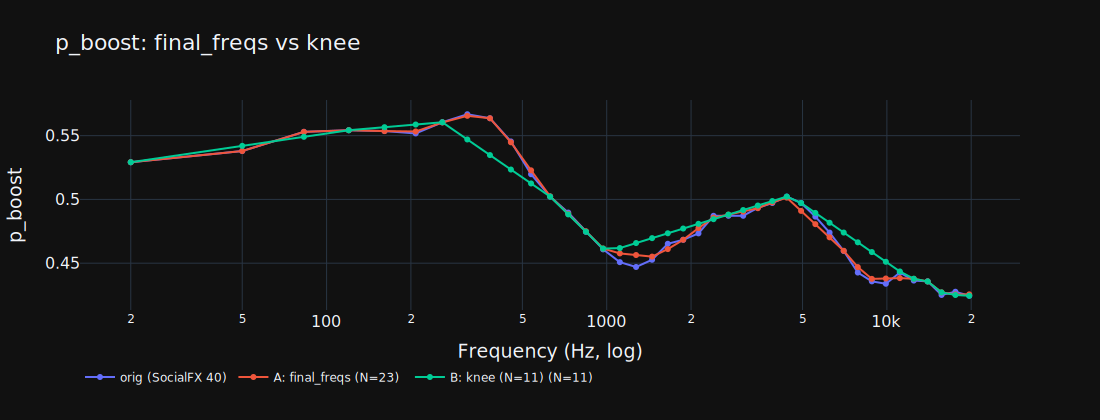

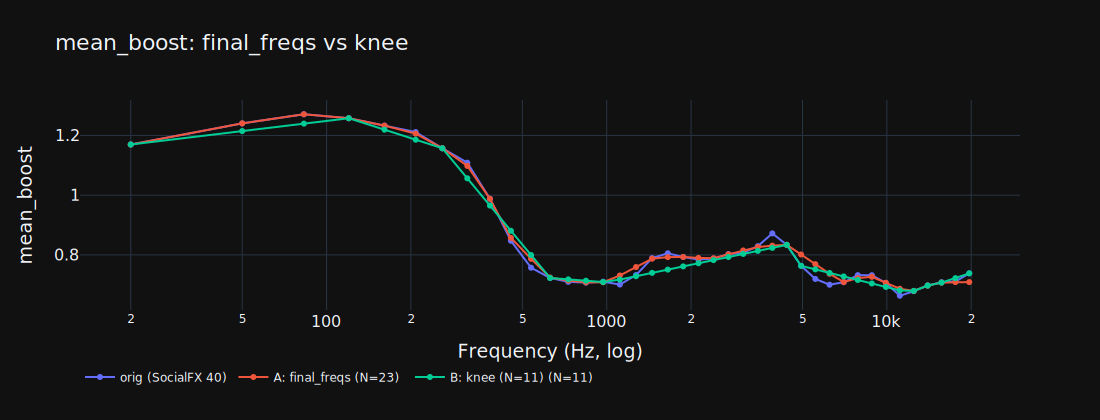

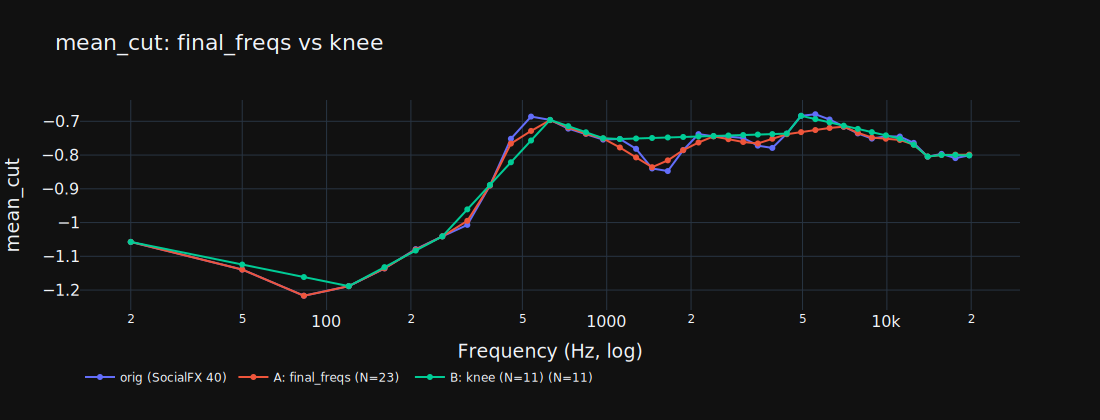

,band_idx,fc_hz,zone
0,1,20.000000,sub_bass
1,2,50.000000,sub_bass
2,3,83.000000,bass
3,4,120.000000,bass
4,5,159.510295,bass
5,6,200.043762,mids
6,7,254.048212,mids
7,8,308.562725,mids
8,9,383.000000,mids
9,10,443.863998,mids


,band_idx,fc_hz,zone
0,1,20.0,sub_bass
1,2,120.0,bass
2,3,259.0,mids
3,4,628.0,mids
4,5,1000.0,mids
5,6,4392.0,presence
6,7,4941.0,presence
7,8,12000.0,air
8,9,14000.0,air
9,10,16000.0,air


In [24]:
# A = твой текущий эквалайзер
freqs_A = np.asarray(final_freqs, float)
label_A = "final_freqs"

# B = knee
kN = int(knee[0]) if "knee" in globals() else None
if kN is None:
    raise ValueError("Не найден knee: переменная knee должна быть (kN, ...)")

freqs_B = np.asarray(models_by_N[kN]["freqs"], float)
label_B = f"knee (N={kN})"

# Графики
fig1 = plot_reconstruction_compare("p_boost", freqs_A, label_A, freqs_B, label_B,
                                   title="p_boost: final_freqs vs knee")
fig2 = plot_reconstruction_compare("mean_boost", freqs_A, label_A, freqs_B, label_B,
                                   title="mean_boost: final_freqs vs knee")
fig3 = plot_reconstruction_compare("mean_cut", freqs_A, label_A, freqs_B, label_B,
                                   title="mean_cut: final_freqs vs knee")

fig1.update_layout(**COMMON_LAYOUT)
fig2.update_layout(**COMMON_LAYOUT)
fig3.update_layout(**COMMON_LAYOUT)

fig1.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top", y=-0.25,
        xanchor="left", x=0,
        font=dict(size=12),
    ),
    margin=dict(b=110)
)
fig2.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top", y=-0.25,
        xanchor="left", x=0,
        font=dict(size=12),
    ),
    margin=dict(b=110)
)
fig3.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top", y=-0.25,
        xanchor="left", x=0,
        font=dict(size=12),
    ),
    margin=dict(b=110)
)

fig1.show(renderer="svg"); fig2.show(renderer="svg"); fig3.show(renderer="svg")

# Таблицы "полоса → зона"
display(describe_bands(freqs_A))
display(describe_bands(freqs_B))



### Вывод

Проведённый анализ показывает, что 40-полосный эквалайзер SocialFX
обладает значительной избыточностью.
Его статистическое поведение может быть воспроизведено:

- почти без потерь — с использованием ~23 полос;
- с приемлемой потерей точности — с использованием ~11 полос.

Таким образом, компактный параметрический эквалайзер
может быть существенно упрощён
без критической деградации описываемых пользовательских решений,
что открывает возможности для более лёгких, быстрых
и интерпретируемых моделей эквализации.

In [31]:
import numpy as np

def roundtrip_40_to_grid_to_40(f40, y40, fgrid):
    yk = log_interp(f40, y40, fgrid)
    yhat = log_interp(fgrid, yk, f40)
    return yhat

def loss_for_grid(f40, y40, fgrid, w=None, kind="value"):
    yhat = roundtrip_40_to_grid_to_40(f40, y40, fgrid)
    if kind == "prob":
        yhat = np.clip(yhat, 0.0, 1.0)
    if w is None:
        return MAE(y40, yhat)
    return WMAE(y40, yhat, w)


In [32]:
def greedy_select_freqs(f_candidates, f40, y40, k=11, w=None, kind="value", force_ends=True):
    f_candidates = np.asarray(f_candidates, float).ravel()
    f_candidates = np.unique(np.sort(f_candidates))

    selected = []

    if force_ends:
        # всегда берём края (обычно помогает стабильности)
        selected = [f_candidates[0], f_candidates[-1]]

    while len(selected) < k:
        best_f = None
        best_loss = None

        for fc in f_candidates:
            if fc in selected:
                continue
            trial = np.sort(np.array(selected + [fc], float))
            L = loss_for_grid(f40, y40, trial, w=w, kind=kind)

            if (best_loss is None) or (L < best_loss):
                best_loss = L
                best_f = fc

        selected.append(best_f)
        selected = list(np.unique(np.sort(selected)))

        # если из-за unique не добрали — продолжим, цикл сам доберёт
        print(f"step {len(selected)}/{k}: add {best_f:.1f} Hz -> loss {best_loss:.6f}")

    return np.asarray(selected[:k], float)

# Пример для mean_boost:
f11_greedy = greedy_select_freqs(
    f_candidates=f40,     # выбираем 11 из 40
    f40=f40,
    y40=social_stats["mean_boost"].to_numpy(float),
    k=11,
    w=w if "w" in locals() else None,
    kind="value",
    force_ends=True,
)

print("f11_greedy:", f11_greedy)


step 3/11: add 11124.0 Hz -> loss 0.080370
step 4/11: add 50.0 Hz -> loss 0.076068
step 5/11: add 1652.0 Hz -> loss 0.067073
step 6/11: add 1114.0 Hz -> loss 0.052828
step 7/11: add 161.0 Hz -> loss 0.036352
step 8/11: add 628.0 Hz -> loss 0.028153
step 9/11: add 318.0 Hz -> loss 0.021859
step 10/11: add 3462.0 Hz -> loss 0.017291
step 11/11: add 537.0 Hz -> loss 0.014718
f11_greedy: [   20.    50.   161.   318.   537.   628.  1114.  1652.  3462. 11124.
 19682.]


In [34]:
import pandas as pd

# твой 23:
f23 = np.asarray(fC, float).ravel()

# твой 11 (если он уже есть в models_by_N — используй его)
# если нет — пропусти этот блок
f11_knee = None
if "models_by_N" in locals() and "knee" in locals():
    kN = int(knee[0])
    f11_knee = np.asarray(models_by_N[kN]["freqs"], float).ravel()

tests = [
    ("23_Kmeans", f23, "value"),
    ("11_greedy", f11_greedy, "value"),
]

if f11_knee is not None and len(f11_knee) == 11:
    tests.append(("11_knee", f11_knee, "value"))

profiles_to_test = [
    ("mean_boost", "value"),
    ("mean_cut", "value"),
    ("p_boost", "prob"),
]

rows = []
for prof, kind in profiles_to_test:
    if prof not in social_stats.columns:
        continue
    y40 = social_stats[prof].to_numpy(float)
    for name, grid, _ in tests:
        L = loss_for_grid(f40, y40, grid, w=w if "w" in locals() else None, kind=kind)
        yhat = roundtrip_40_to_grid_to_40(f40, y40, grid)
        if kind == "prob":
            yhat = np.clip(yhat, 0.0, 1.0)
        rows.append({
            "profile": prof,
            "grid": name,
            "N": len(grid),
            "loss": L,
            "MAE": MAE(y40, yhat),
            "MAX": float(np.max(np.abs(y40 - yhat))),
        })

df_cmp = pd.DataFrame(rows).sort_values(["profile", "N", "loss"])
display(df_cmp)


,profile,grid,N,loss,MAE,MAX
1,mean_boost,11_greedy,11,0.014718,0.014718,0.059783
2,mean_boost,11_knee,11,0.017341,0.017341,0.054573
0,mean_boost,23_Kmeans,23,0.009828,0.009828,0.049484
5,mean_cut,11_knee,11,0.018047,0.018047,0.099493
4,mean_cut,11_greedy,11,0.023524,0.023524,0.083726
3,mean_cut,23_Kmeans,23,0.010244,0.010244,0.048323
7,p_boost,11_greedy,11,0.005218,0.005218,0.019238
8,p_boost,11_knee,11,0.006915,0.006915,0.028888
6,p_boost,23_Kmeans,23,0.002014,0.002014,0.009357


In [37]:
import plotly.graph_objects as go
import numpy as np

def roundtrip(f40, y40, fk, kind="value"):
    yk = log_interp(f40, y40, fk)
    yhat = log_interp(fk, yk, f40)
    if kind == "prob":
        yhat = np.clip(yhat, 0.0, 1.0)
    return yhat

def plot_worstcase_profile_plotly(profile_name="mean_cut", kind="value"):
    y40 = social_stats[profile_name].to_numpy(float)

    y23 = roundtrip(f40, y40, fC, kind=kind)
    y11k = roundtrip(f40, y40, f11_knee, kind=kind)
    y11g = roundtrip(f40, y40, f11_greedy, kind=kind)

    e23  = y23  - y40
    e11k = y11k - y40
    e11g = y11g - y40

    abs_stack = np.vstack([np.abs(e23), np.abs(e11k), np.abs(e11g)])
    i_star = int(np.argmax(np.max(abs_stack, axis=0)))
    f_star = float(f40[i_star])

    win = 4
    i0 = max(0, i_star - win)
    i1 = min(len(f40)-1, i_star + win)
    sl = slice(i0, i1+1)

    # === FIGURE 1: curves ===
    fig1 = go.Figure()

    fig1.add_trace(go.Scatter(
        x=f40[sl], y=y40[sl],
        mode="lines+markers",
        name=f"{profile_name} (orig)"
    ))
    fig1.add_trace(go.Scatter(
        x=f40[sl], y=y23[sl],
        mode="lines+markers",
        name="23_yours"
    ))
    fig1.add_trace(go.Scatter(
        x=f40[sl], y=y11k[sl],
        mode="lines+markers",
        name="11_knee"
    ))
    fig1.add_trace(go.Scatter(
        x=f40[sl], y=y11g[sl],
        mode="lines+markers",
        name="11_greedy"
    ))

    fig1.add_vline(x=f_star, line_dash="dash")

    fig1.update_layout(
        title=f"Worst-case @ {f_star:.0f} Hz ({profile_name})",
        xaxis_type="log",
        xaxis_title="Frequency (Hz)",
        yaxis_title="Value",
    )

    fig1.show()

    # === FIGURE 2: errors ===
    fig2 = go.Figure()

    fig2.add_trace(go.Scatter(
        x=f40[sl], y=e23[sl],
        mode="lines+markers",
        name="err 23"
    ))
    fig2.add_trace(go.Scatter(
        x=f40[sl], y=e11k[sl],
        mode="lines+markers",
        name="err 11_knee"
    ))
    fig2.add_trace(go.Scatter(
        x=f40[sl], y=e11g[sl],
        mode="lines+markers",
        name="err 11_greedy"
    ))

    fig2.add_hline(y=0)
    fig2.add_vline(x=f_star, line_dash="dash")

    fig2.update_layout(
        title=f"Errors around worst-case ({profile_name})",
        xaxis_type="log",
        xaxis_title="Frequency (Hz)",
        yaxis_title="Error",
    )

    fig2.show()

    print(f"[{profile_name}] worst-case @ {f_star:.1f} Hz")
    print(f"  |err| 23:  {abs(e23[i_star]):.6f}")
    print(f"  |err| 11k: {abs(e11k[i_star]):.6f}")
    print(f"  |err| 11g: {abs(e11g[i_star]):.6f}")


In [38]:
plot_worstcase_profile_plotly("mean_cut", kind="value")
plot_worstcase_profile_plotly("p_boost", kind="prob")


[mean_cut] worst-case @ 1652.0 Hz
  |err| 23:  0.031643
  |err| 11k: 0.099493
  |err| 11g: 0.000000


[p_boost] worst-case @ 383.0 Hz
  |err| 23:  0.000000
  |err| 11k: 0.028888
  |err| 11g: 0.013556


In [40]:
import numpy as np
import pandas as pd
from pathlib import Path

f40 = np.asarray(f40, float).ravel()
f23 = np.asarray(fC, float).ravel()
assert len(f40) == 40, f"len(f40)={len(f40)}"
assert len(f23) == 23, f"len(fC)={len(f23)}"

kN = int(knee[0])
f11_knee = np.asarray(models_by_N[kN]["freqs"], float).ravel()
assert len(f11_knee) == kN, f"len(f11_knee)={len(f11_knee)} vs kN={kN}"

have_greedy11 = "f11_greedy" in locals()
if have_greedy11:
    f11_greedy = np.asarray(f11_greedy, float).ravel()
    assert len(f11_greedy) == 11

w40 = np.asarray(w, float).ravel() if "w" in locals() else np.ones_like(f40, float)
assert len(w40) == 40

# -----------------------------
# 1) Прямой roundtrip 40->K->40 (через log_interp)
# -----------------------------
def roundtrip_40_K_40(y40, fk, kind="value"):
    yk = log_interp(f40, y40, fk)
    yhat = log_interp(fk, yk, f40)
    if kind == "prob":
        yhat = np.clip(yhat, 0.0, 1.0)
    return yhat


def apply_delta_C_on_23(y40, delta_C, kind="value"):
    # y40 -> y23 -> (y23 + delta) -> back to 40
    y23 = A_40_to_C @ y40
    y23_cal = y23 + delta_C
    y40_cal = A_C_to_40 @ y23_cal
    if kind == "prob":
        y40_cal = np.clip(y40_cal, 0.0, 1.0)
    return y40_cal

have_delta = "delta_C_transfer" in locals()  # ты сам можешь задать эту переменную


profiles = [
    ("mean_boost", "value"),
    ("mean_cut", "value"),
    ("p_boost", "prob"),
]
profiles = [(p,k) for p,k in profiles if p in social_stats.columns]

grids = [
    ("23_yours", f23),
    ("11_knee", f11_knee),
]
if have_greedy11:
    grids.append(("11_greedy", f11_greedy))

# -----------------------------
# 4) Считаем метрики
# -----------------------------
rows = []
for prof, kind in profiles:
    y40 = social_stats[prof].to_numpy(float)

    # baseline 23
    yhat23 = roundtrip_40_K_40(y40, f23, kind=kind)
    mae23 = MAE(y40, yhat23)
    wmae23 = WMAE(y40, yhat23, w40)
    max23 = float(np.max(np.abs(y40 - yhat23)))

    # все остальные
    for grid_name, fk in grids:
        yhat = roundtrip_40_K_40(y40, fk, kind=kind)
        mae = MAE(y40, yhat)
        wmae = WMAE(y40, yhat, w40)
        mx = float(np.max(np.abs(y40 - yhat)))

        rows.append({
            "profile": prof,
            "kind": kind,
            "grid": grid_name,
            "N": len(fk),
            "MAE": mae,
            "WMAE": wmae,
            "MAX": mx,
            # потери относительно 23 (в процентах)
            "MAE_vs_23_%": 100.0 * (mae / (mae23 + 1e-12) - 1.0),
            "WMAE_vs_23_%": 100.0 * (wmae / (wmae23 + 1e-12) - 1.0),
            "MAX_vs_23_%": 100.0 * (mx / (max23 + 1e-12) - 1.0),
        })

    # опционально: 23 + перенос delta_C_transfer
    if have_delta:
        delta_C = np.asarray(delta_C_transfer, float).ravel()
        assert len(delta_C) == 23, f"delta_C_transfer must be len 23, got {len(delta_C)}"
        yhat_cal = apply_delta_C_on_23(y40, delta_C, kind=kind)
        mae = MAE(y40, yhat_cal)
        wmae = WMAE(y40, yhat_cal, w40)
        mx = float(np.max(np.abs(y40 - yhat_cal)))
        rows.append({
            "profile": prof,
            "kind": kind,
            "grid": "23_yours+delta_transfer",
            "N": 23,
            "MAE": mae,
            "WMAE": wmae,
            "MAX": mx,
            "MAE_vs_23_%": 100.0 * (mae / (mae23 + 1e-12) - 1.0),
            "WMAE_vs_23_%": 100.0 * (wmae / (wmae23 + 1e-12) - 1.0),
            "MAX_vs_23_%": 100.0 * (mx / (max23 + 1e-12) - 1.0),
        })

df = pd.DataFrame(rows).sort_values(["profile", "N", "grid"])
display(df)

# -----------------------------
# 5) Сохраняем
# -----------------------------
OUT = Path("robustness_out")
OUT.mkdir(exist_ok=True)
df.to_csv(OUT / "roundtrip_40_23_11_compare.csv", index=False)
print("Saved:", (OUT / "roundtrip_40_23_11_compare.csv").resolve())


,profile,kind,grid,N,MAE,WMAE,MAX,MAE_vs_23_%,WMAE_vs_23_%,MAX_vs_23_%
2,mean_boost,value,11_greedy,11,0.014718,0.014718,0.059783,4.975596e+01,4.975596e+01,2.081269e+01
1,mean_boost,value,11_knee,11,0.017341,0.017341,0.054573,7.645234e+01,7.645234e+01,1.028411e+01
0,mean_boost,value,23_yours,23,0.009828,0.009828,0.049484,-1.017524e-08,-1.017524e-08,-2.020850e-09
5,mean_cut,value,11_greedy,11,0.023524,0.023524,0.083726,1.296289e+02,1.296289e+02,7.326225e+01
4,mean_cut,value,11_knee,11,0.018047,0.018047,0.099493,7.616714e+01,7.616714e+01,1.058908e+02
3,mean_cut,value,23_yours,23,0.010244,0.010244,0.048323,-9.761458e-09,-9.761458e-09,-2.069389e-09
8,p_boost,prob,11_greedy,11,0.005218,0.005218,0.019238,1.591381e+02,1.591381e+02,1.056068e+02
7,p_boost,prob,11_knee,11,0.006915,0.006915,0.028888,2.434340e+02,2.434340e+02,2.087437e+02
6,p_boost,prob,23_yours,23,0.002014,0.002014,0.009357,-4.966411e-08,-4.966411e-08,-1.068751e-08


Saved: C:\Users\makcc\PycharmProjects\EarLoop\research\compact_eq_design\robustness_out\roundtrip_40_23_11_compare.csv


In [41]:
import numpy as np
import pandas as pd
from pathlib import Path

OUT = Path("exports_listening")
(OUT / "grids").mkdir(parents=True, exist_ok=True)
(OUT / "profiles").mkdir(parents=True, exist_ok=True)

# ---- grids ----
f40 = np.asarray(f40, float).ravel()
f23 = np.asarray(fC, float).ravel()

kN = int(knee[0])
f11_knee = np.asarray(models_by_N[kN]["freqs"], float).ravel()

pd.DataFrame({"fc_hz": f40}).to_csv(OUT/"grids"/"grid_40.csv", index=False)
pd.DataFrame({"fc_hz": f23}).to_csv(OUT/"grids"/"grid_23.csv", index=False)
pd.DataFrame({"fc_hz": f11_knee}).to_csv(OUT/"grids"/"grid_11_knee.csv", index=False)

if "f11_greedy" in locals():
    f11_greedy = np.asarray(f11_greedy, float).ravel()
    pd.DataFrame({"fc_hz": f11_greedy}).to_csv(OUT/"grids"/"grid_11_greedy.csv", index=False)

print("Saved grids to", (OUT/"grids").resolve())

# ---- helper: project 40-profile -> K-grid via your log_interp ----
def project_40_to_grid(y40, fk, kind="value"):
    yk = log_interp(f40, y40, fk)  # value on fk grid
    if kind == "prob":
        yk = np.clip(yk, 0.0, 1.0)
    return yk

# ---- choose 3 profiles on 40 ----
# ты можешь поменять набор тут
profiles = [
    ("mean_boost", "value"),
    ("mean_cut", "value"),
    ("p_boost", "prob"),
]
profiles = [(p,k) for p,k in profiles if p in social_stats.columns]
assert len(profiles) == 3, f"Expected 3 profiles available, got: {profiles}"

def save_profile(name, fk, yk, kind):
    # для prob сохраним как 0..1, а для EQ-движка позже переведём в dB (или применим как gain)
    df = pd.DataFrame({"fc_hz": fk, "value": yk, "kind": kind})
    df.to_csv(OUT/"profiles"/name, index=False)

for prof, kind in profiles:
    y40 = social_stats[prof].to_numpy(float)

    # 40
    save_profile(f"profile_{prof}_40.csv", f40, y40, kind)

    # 23
    y23 = project_40_to_grid(y40, f23, kind=kind)
    save_profile(f"profile_{prof}_23.csv", f23, y23, kind)

    # 11 knee
    y11k = project_40_to_grid(y40, f11_knee, kind=kind)
    save_profile(f"profile_{prof}_11_knee.csv", f11_knee, y11k, kind)

    # 11 greedy optional
    if (OUT/"grids"/"grid_11_greedy.csv").exists():
        f11g = pd.read_csv(OUT/"grids"/"grid_11_greedy.csv")["fc_hz"].to_numpy(float)
        y11g = project_40_to_grid(y40, f11g, kind=kind)
        save_profile(f"profile_{prof}_11_greedy.csv", f11g, y11g, kind)

print("Saved profiles to", (OUT/"profiles").resolve())
print("Done.")


Saved grids to C:\Users\makcc\PycharmProjects\EarLoop\research\compact_eq_design\exports_listening\grids
Saved profiles to C:\Users\makcc\PycharmProjects\EarLoop\research\compact_eq_design\exports_listening\profiles
Done.


In [42]:
import numpy as np
import pandas as pd
from pathlib import Path

# ожидаем, что f40 уже есть
f40 = np.asarray(f40, float).ravel()
lf = np.log10(f40)

def gauss_log(f0_hz, width_oct, gain_db):
    """Гаусс в log10(f). width_oct ~ ширина в октавах (примерно)."""
    mu = np.log10(f0_hz)
    # 1 октава = log10(2)
    sigma = (width_oct * np.log10(2)) / 2.355  # FWHM->sigma (приблизительно)
    return gain_db * np.exp(-0.5 * ((lf - mu) / sigma) ** 2)

def tilt(low_db=-3.0, high_db=3.0):
    """Линейный наклон в log частоте от low_db на min до high_db на max."""
    t = (lf - lf.min()) / (lf.max() - lf.min())
    return low_db + t * (high_db - low_db)

presets = {}

# 1) Smile
presets["smile"] = (
    gauss_log(80, 1.6, +6) +
    gauss_log(2500, 1.2, -3) +
    gauss_log(12000, 1.4, +5)
)

# 2) Vocal clarity
presets["vocal_clarity"] = (
    gauss_log(250, 1.3, -3) +
    gauss_log(3200, 0.9, +4) +
    gauss_log(9000, 1.2, +2)
)

# 3) Stress: narrow notch @ 1650 Hz
presets["notch_1650_narrow"] = (
    gauss_log(1650, 0.35, -9)  # узко
)

# 4) Stress: narrow peak @ 6500 Hz
presets["peak_6500_narrow"] = (
    gauss_log(6500, 0.35, +6)
)

# 5) Comb (через полосу)
comb = np.zeros_like(f40)
comb[::2] = +3
comb[1::2] = -3
presets["comb_alt"] = comb

# 6) App-like tilt + dip
presets["app_like"] = (
    tilt(-1.5, +3.5) +
    gauss_log(800, 1.0, -2.5)
)

# clip to sane range
for k in presets:
    presets[k] = np.clip(presets[k], -12, +12)

OUT = Path("exports_listening/presets")
OUT.mkdir(parents=True, exist_ok=True)

for name, gdb in presets.items():
    df = pd.DataFrame({"fc_hz": f40, "gain_db": gdb})
    df.to_csv(OUT / f"preset_{name}_40.csv", index=False)

print("Saved:", len(presets), "presets to", OUT.resolve())


Saved: 6 presets to C:\Users\makcc\PycharmProjects\EarLoop\research\compact_eq_design\exports_listening\presets


In [43]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob

BASE = Path("exports_listening")
PRESET_DIR = BASE / "presets"
OUT_DIR = BASE / "presets_projected"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- grids ---
f40 = np.asarray(f40, float).ravel()
f23 = np.asarray(fC, float).ravel()

kN = int(knee[0])
f11_knee = np.asarray(models_by_N[kN]["freqs"], float).ravel()

have_greedy11 = "f11_greedy" in locals()
if have_greedy11:
    f11_greedy = np.asarray(f11_greedy, float).ravel()

assert len(f40) == 40 and len(f23) == 23 and len(f11_knee) == kN

# --- helper: project using log_interp (values on new grid) ---
def project_log(y40, fk):
    return log_interp(f40, y40, fk)

# --- helper: project using A_40_to_C if available for 23 ---
def project_23(y40):
    # try matrix projection if present and compatible
    if "A_40_to_C" in locals():
        A = A_40_to_C
        try:
            if A.shape == (23, 40):
                return (A @ np.asarray(y40, float)).ravel()
        except Exception:
            pass
    # fallback
    return project_log(y40, f23)

# --- load all preset_*_40.csv ---
files = sorted(PRESET_DIR.glob("preset_*_40.csv"))
if not files:
    raise FileNotFoundError(f"No presets found in {PRESET_DIR}. Run preset generation first.")

print("Found presets:", [f.name for f in files])

for fp in files:
    df = pd.read_csv(fp)
    if not {"fc_hz", "gain_db"}.issubset(df.columns):
        raise ValueError(f"{fp.name} must contain columns fc_hz,gain_db")

    # sanity: ensure this is 40-band preset aligned with f40
    y40 = df["gain_db"].to_numpy(float).ravel()
    if len(y40) != 40:
        raise ValueError(f"{fp.name}: expected 40 gains, got {len(y40)}")

    # --- 23 ---
    y23 = project_23(y40)
    if len(y23) != 23:
        raise RuntimeError(f"{fp.name}: projection to 23 failed, got {len(y23)}")

    out23 = OUT_DIR / fp.name.replace("_40.csv", "_23.csv")
    pd.DataFrame({"fc_hz": f23, "gain_db": y23}).to_csv(out23, index=False)

    # --- 11 knee ---
    y11k = project_log(y40, f11_knee)
    out11k = OUT_DIR / fp.name.replace("_40.csv", "_11_knee.csv")
    pd.DataFrame({"fc_hz": f11_knee, "gain_db": y11k}).to_csv(out11k, index=False)

    # --- 11 greedy (optional) ---
    if have_greedy11:
        y11g = project_log(y40, f11_greedy)
        out11g = OUT_DIR / fp.name.replace("_40.csv", "_11_greedy.csv")
        pd.DataFrame({"fc_hz": f11_greedy, "gain_db": y11g}).to_csv(out11g, index=False)

print("Saved projected presets to:", OUT_DIR.resolve())


Found presets: ['preset_app_like_40.csv', 'preset_comb_alt_40.csv', 'preset_notch_1650_narrow_40.csv', 'preset_peak_6500_narrow_40.csv', 'preset_smile_40.csv', 'preset_vocal_clarity_40.csv']
Saved projected presets to: C:\Users\makcc\PycharmProjects\EarLoop\research\compact_eq_design\exports_listening\presets_projected


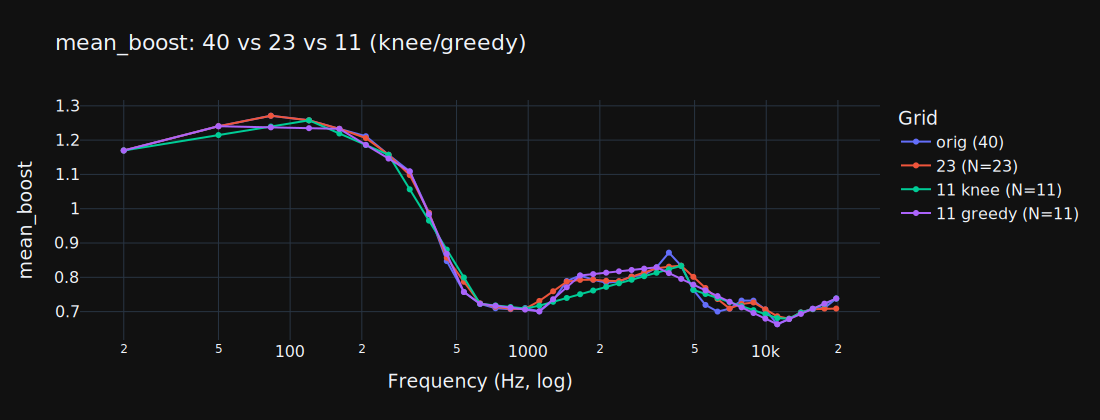

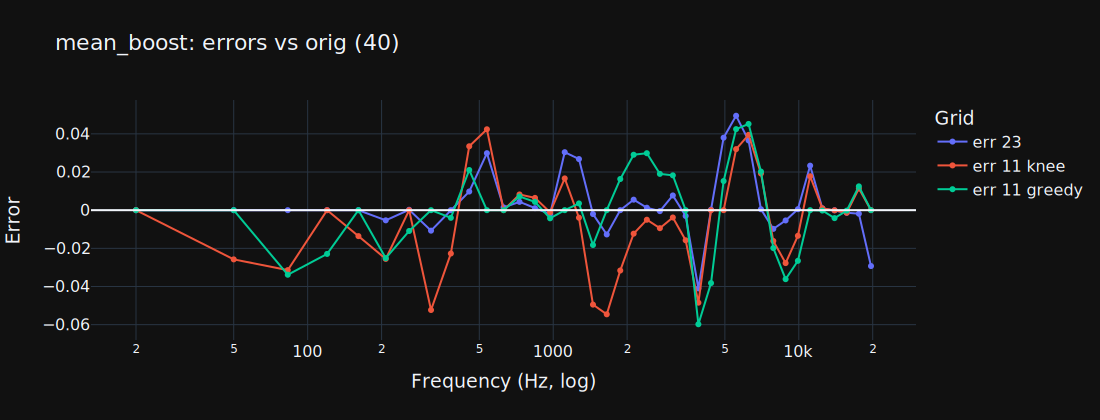

In [46]:
import numpy as np
import plotly.graph_objects as go

def plot_profile_with_grids(profile="mean_boost", kind="value",
                            f23=None, f11_knee=None, f11_greedy=None,
                            title=None):
    y40 = social_stats[profile].to_numpy(float)

    # 40->K (значения на сетке K), затем обратно K->40 (для честного сравнения формы на f40)
    def rt(fk):
        yk = log_interp(f40, y40, fk)
        yhat = log_interp(fk, yk, f40)
        if kind == "prob":
            yhat = np.clip(yhat, 0, 1)
        return yhat

    y23 = rt(f23)
    y11k = rt(f11_knee)
    y11g = rt(f11_greedy) if f11_greedy is not None else None

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=f40, y=y40, mode="lines+markers", name="orig (40)"))
    fig.add_trace(go.Scatter(x=f40, y=y23, mode="lines+markers", name=f"23 (N={len(f23)})"))
    fig.add_trace(go.Scatter(x=f40, y=y11k, mode="lines+markers", name=f"11 knee (N={len(f11_knee)})"))
    if y11g is not None:
        fig.add_trace(go.Scatter(x=f40, y=y11g, mode="lines+markers", name=f"11 greedy (N={len(f11_greedy)})"))

    fig.update_layout(
        title=title or f"{profile}: 40 vs 23 vs 11 (knee/greedy)",
        xaxis_title="Frequency (Hz, log)",
        yaxis_title=profile,
        xaxis_type="log",
        legend_title="Grid"
    )
    fig.update_layout(**COMMON_LAYOUT)
    fig.show(renderer="svg")

    # Ошибка на той же оси (очень полезно, чтобы не спорить “на глаз”)
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=f40, y=(y23 - y40), mode="lines+markers", name="err 23"))
    fig2.add_trace(go.Scatter(x=f40, y=(y11k - y40), mode="lines+markers", name="err 11 knee"))
    if y11g is not None:
        fig2.add_trace(go.Scatter(x=f40, y=(y11g - y40), mode="lines+markers", name="err 11 greedy"))

    fig2.add_hline(y=0)
    fig2.update_layout(
        title=f"{profile}: errors vs orig (40)",
        xaxis_title="Frequency (Hz, log)",
        yaxis_title="Error",
        xaxis_type="log",
        legend_title="Grid"
    )
    fig2.update_layout(**COMMON_LAYOUT)
    fig2.show(renderer="svg")

# Пример вызова (переименуй переменные под свой ноут):
plot_profile_with_grids(
    profile="mean_boost",
    kind="value",
    f23=fC,
    f11_knee=f11_knee,
    f11_greedy=(f11_greedy if "f11_greedy" in globals() else None),
)
